In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

DATA_DIRECTORY = '/content/drive/MyDrive/Vegetable Image Dataset/Vegetable Images'

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 2.3456 Acc: 0.1645
validation Loss: 1.8726 Acc: 0.2917
Epoch 2/10
----------
train Loss: 1.7209 Acc: 0.3818
validation Loss: 1.6487 Acc: 0.4260
Epoch 3/10
----------
train Loss: 1.4822 Acc: 0.4922
validation Loss: 1.2549 Acc: 0.5637
Epoch 4/10
----------
train Loss: 1.3126 Acc: 0.5597
validation Loss: 1.0114 Acc: 0.6403
Epoch 5/10
----------
train Loss: 1.1988 Acc: 0.5998
validation Loss: 0.8479 Acc: 0.7070
Epoch 6/10
----------
train Loss: 1.1269 Acc: 0.6258
validation Loss: 0.8934 Acc: 0.7017
Epoch 7/10
----------
train Loss: 1.0441 Acc: 0.6573
validation Loss: 0.6950 Acc: 0.7573
Epoch 8/10
----------
train Loss: 0.9889 Acc: 0.6769
validation Loss: 0.6537 Acc: 0.7680
Epoch 9/10
----------
train Loss: 0.9532 Acc: 0.6855
validation Loss: 0.6341 Acc: 0.7833
Epoch 10/10
----------
train Loss: 0.9299 Acc: 0.6922
validation Loss: 0.6911 Acc: 0.7667
Best validation Acc: 0.783333


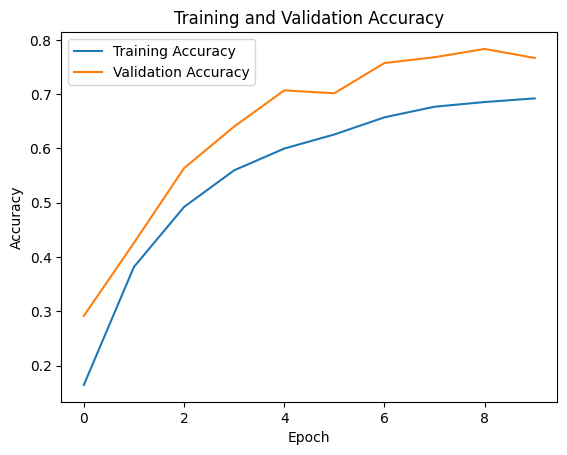

Test Accuracy: 0.7690
Precision: 0.7870
Recall: 0.7690
F1 Score: 0.7694
Mean Loss: 0.7000
              precision    recall  f1-score   support

        Bean       0.50      0.56      0.53       200
Bitter_Gourd       0.69      0.78      0.73       200
Bottle_Gourd       0.96      0.63      0.76       200
     Brinjal       0.70      0.69      0.70       200
    Broccoli       0.75      0.82      0.78       200
     Cabbage       0.76      0.61      0.68       200
    Capsicum       0.98      0.81      0.89       200
      Carrot       0.94      0.94      0.94       200
 Cauliflower       0.89      0.77      0.82       200
    Cucumber       0.64      0.74      0.69       200
      Papaya       0.78      0.83      0.80       200
      Potato       0.79      0.99      0.88       200
     Pumpkin       0.66      0.91      0.76       200
      Radish       0.85      0.85      0.85       200
      Tomato       0.92      0.61      0.74       200

    accuracy                           0.77 

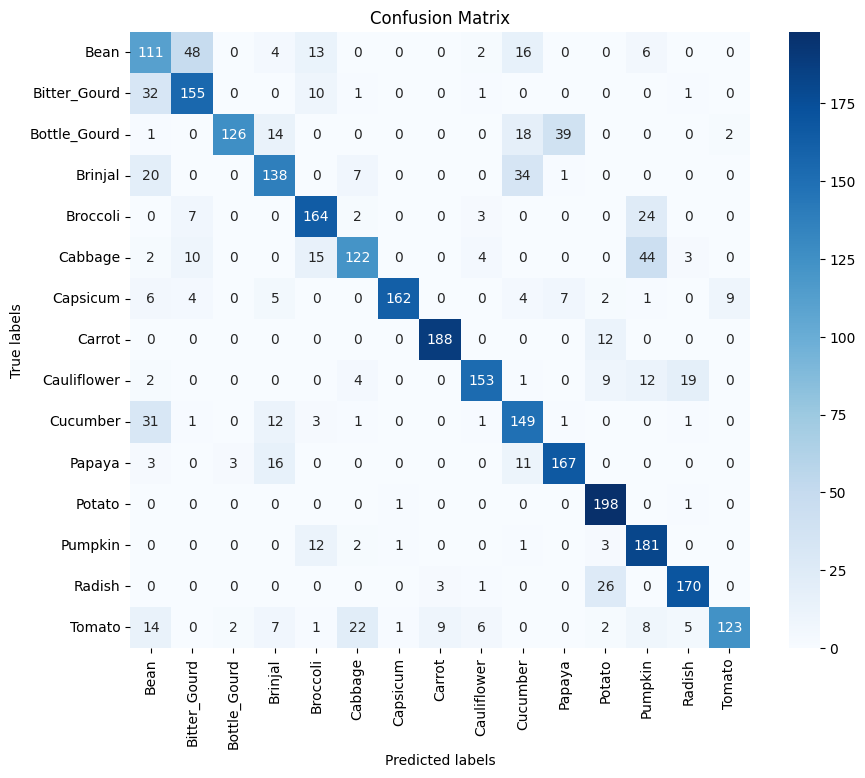

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

def load_datasets():
    return {x: datasets.ImageFolder(os.path.join(DATA_DIRECTORY, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

def create_dataloaders(image_datasets):
    return {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'validation', 'test']}

def setup_model():
    model = models.alexnet(pretrained=False)
    for param in model.parameters():
        param.requires_grad = True  # Set requires_grad to True for fine-tuning
    num_output_classes = len(image_datasets['train'].classes)
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, num_output_classes)  # Adding a new layer for classification
    )
    return model.to(device)

def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        if val_acc_history[-1] > best_acc:
            best_acc = val_acc_history[-1]

    print('Best validation Acc: {:4f}'.format(best_acc))

    plt.plot(range(len(train_acc_history)), train_acc_history, label='Training Accuracy')
    plt.plot(range(len(val_acc_history)), val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mean_loss = np.mean(losses)

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Mean Loss: {mean_loss:.4f}')

    print(classification_report(y_true, y_pred, target_names=image_datasets['test'].classes))

    return y_true, y_pred

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

image_datasets = load_datasets()
dataloaders = create_dataloaders(image_datasets)
model = setup_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, criterion, optimizer, num_epochs=10)

y_true, y_pred = evaluate_model(model, dataloaders['test'])

conf_matrix = confusion_matrix(y_true, y_pred)
class_names = image_datasets['test'].classes
plot_confusion_matrix(conf_matrix, class_names)